# Baseline Analysis: LV Feeder

This notebook establishes the **baseline operating condition** of a CSIRO low-voltage (LV) radial feeder before introducing EVs, batteries, or D-Suite devices.

The baseline is used as a **reference case** to understand:
- existing voltage behaviour,
- loading patterns,
- and constraint activation under normal demand.

All future scenarios are compared back to this baseline.

This collection was used:

> Heidarihaei, Rahmatollah; Geth, Frederik; & Sander, Claeys (2024): Four-wire low voltage power network dataset. v1. CSIRO. Data Collection. 
> https://doi.org/10.25919/jaae-vc35


### Workflow overview

This baseline analysis follows three steps:

1. **Identify the correct CSIRO LV feeder**
   - Screen available networks in `00_*.ipynb`
   - Select a representative radial LV feeder

2. **Solve and analyse the baseline**
   - Run power flow / OPF with no EVs or D-Suite devices
   - Plot voltage profiles along the feeder
   - Check compliance with AS 60038 voltage limits.


## 4-Wire Feeder 

### Selected feeder

The feeder used in this study was selected by screening the CSIRO four-wire LV dataset to identify a **small, interpretable, radial network** suitable for intuition-building.

Selection criteria:
- Four-wire representation
- Radial topology
- Fewer than 100 buses
- Moderate number of customer loads

Chosen feeder:
- Dataset: CSIRO four-wire low voltage power network dataset
- Network: network_20
- Feeder: Feeder_5
- Size: ~65 buses, ~23 loads

This feeder is small enough to visualise clearly, while still exhibiting realistic voltage drop behaviour.


In [1]:
import Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
Pkg.instantiate()

using PowerModelsDistribution
using Ipopt
using JuMP
using LinearAlgebra

const PMD = PowerModelsDistribution

  Activating project at `/mnt/c/Users/auc009/OneDrive - CSIRO/Documents/power-models-distribution/pmd_ev_experiments`


PowerModelsDistribution

In [14]:
file = "../data/Three-wire-Kron-reduced/network_1/Feeder_1/Master.dss"

ipopt_solver = JuMP.optimizer_with_attributes(Ipopt.Optimizer, "print_level"=>1, "sb"=>"yes","warm_start_init_point"=>"yes")

MathOptInterface.OptimizerWithAttributes(IpoptMathOptInterfaceExt.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute, Any}[MathOptInterface.RawOptimizerAttribute("print_level") => 1, MathOptInterface.RawOptimizerAttribute("sb") => "yes", MathOptInterface.RawOptimizerAttribute("warm_start_init_point") => "yes"])

In [15]:
eng4w = parse_file(file, transformations=[transform_loops!])

[ PowerModelsDistribution | Info ] : Circuit has been reset with the 'clear' on line 18 in 'Master.dss'
[ PowerModelsDistribution | Info ] : Redirecting to 'linecode.txt' on line 22 in 'Master.dss'
[ PowerModelsDistribution | Info ] : Redirecting to 'lines.txt' on line 23 in 'LineCode.txt'
[ PowerModelsDistribution | Info ] : Redirecting to 'loads.txt' on line 24 in 'Lines.txt'
[ PowerModelsDistribution | Info ] : Command 'solve' on line 29 in 'Master.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : Command 'closedi' on line 30 in 'Master.dss' is not supported, skipping.
[ PowerModelsDistribution | Info ] : basemva=100 is the default value, you may want to adjust sbase_default for better convergence
┌ PowerModelsDistribution | Warning ] : basefreq=60.0 on line.line865 does not match circuit basefreq=50.0
└ @ PowerModelsDistribution ~/.julia/packages/PowerModelsDistribution/EOTxp/src/data_model/transformations/dss2eng.jl:422
┌ PowerModelsDistribution | Warning ] : b

Dict{String, Any} with 10 entries:
  "voltage_source" => Dict{String, Any}("source"=>Dict{String, Any}("source_id"…
  "name"           => "enwl_network_1_feeder_1_kron"
  "line"           => Dict{String, Any}("line865"=>Dict{String, Any}("length"=>…
  "conductor_ids"  => [1, 2, 3, 4]
  "settings"       => Dict{String, Any}("sbase_default"=>100000.0, "vbases_defa…
  "files"          => ["../data/Three-wire-Kron-reduced/network_1/Feeder_1/Mast…
  "load"           => Dict{String, Any}("load34"=>Dict{String, Any}("source_id"…
  "bus"            => Dict{String, Any}("1"=>Dict{String, Any}("rg"=>Float64[],…
  "linecode"       => Dict{String, Any}("lc7"=>Dict{String, Any}("b_fr"=>[0.0 0…
  "data_model"     => ENGINEERING

In [16]:
eng4w["settings"]["sbase_default"] = 1
eng4w["voltage_source"]["source"]["rs"] *= 0 
eng4w["voltage_source"]["source"]["xs"] *= 0
eng4w["is_kron_reduced"] = true    #Activate only for 3 wire networks

math4w = transform_data_model(eng4w, multinetwork=false, kron_reduce=false, phase_project=false)

Dict{String, Any} with 18 entries:
  "is_kron_reduced" => true
  "conductor_ids"   => [1, 2, 3, 4]
  "time_elapsed"    => 1.0
  "bus"             => Dict{String, Any}("1"=>Dict{String, Any}("vm_pair_lb"=>T…
  "name"            => "enwl_network_1_feeder_1_kron"
  "map"             => Dict{String, Any}[Dict("unmap_function"=>"_map_math2eng_…
  "settings"        => Dict{String, Any}("sbase_default"=>1, "vbases_default"=>…
  "gen"             => Dict{String, Any}("1"=>Dict{String, Any}("pg"=>[0.0, 0.0…
  "branch"          => Dict{String, Any}("1"=>Dict{String, Any}("br_r"=>[2.3666…
  "storage"         => Dict{String, Any}()
  "switch"          => Dict{String, Any}()
  "is_projected"    => false
  "per_unit"        => true
  "data_model"      => MATHEMATICAL
  "shunt"           => Dict{String, Any}()
  "transformer"     => Dict{String, Any}()
  "bus_lookup"      => Dict{Any, Int64}("1"=>1, "519"=>2, "788"=>3, "774"=>4, "…
  "load"            => Dict{String, Any}("32"=>Dict{String, Any}("mod

In [17]:
# for (i, bus) in math4w["bus"] 
#   bus["vmin"] = [0.9 * ones(3) ; 0 ] 
#  bus["vmax"] = [1.1 * ones(3) ; Inf] 
# end

# for (i, load) in math4w["load"] 
#     load["pd"] *= 4 
#     load["qd"] *= 4 
# end

In [18]:
println("Running unbalanced AC Optimal Power Flow with Ipopt...") 

result_opf = solve_mc_opf( math4w, ACPUPowerModel, ipopt_solver) 

println("OPF solve status: ", result_opf["termination_status"]) 
println("Objective value (if any): ", get(result_opf, "objective", missing))

Running unbalanced AC Optimal Power Flow with Ipopt...


LoadError: BoundsError: attempt to access 1-element Vector{Float64} at index [2]

### Plotting

In [18]:
function get_bus_name_phases(bus_name)
    bus_split = split(bus_name, ".")
    bus = bus_split[1]
    bus_phases = parse.(Int64, bus_split[2:end])

    return (bus, bus_phases)
end

get_bus_name_phases (generic function with 1 method)

In [19]:
function plot_voltage_along_feeder_snap(buses_dict, lines_df; t=1, Vthreshold=1000, vmin = 0.94*230, vmax = 1.1*230)
    # plot(1:10)
    p = plot(legend=false)
    ylabel!("Voltage magnitude P-N (V)")
    title!("Voltage drop along feeder")
    xlabel!("Distance from reference bus (km)")
    colors = [:blue, :red, :black]
    for line in DataFrames.eachrow(lines_df)
        (bus1_name, bus1_phases) = get_bus_name_phases(line.Bus1)
        (bus2_name, bus2_phases) = get_bus_name_phases(line.Bus2)
        @assert length(bus1_phases) == length(bus2_phases)
        for c in 1:length(bus1_phases)
            dist_f_bus = buses_dict[bus1_name]["distance"]
            dist_t_bus = buses_dict[bus2_name]["distance"]
            phase = bus1_phases[c]
            vm_f = 1000
            vm_t = 1000
            if phase == 1
                vm_f = buses_dict[bus1_name]["vma"][t]
                vm_t = buses_dict[bus2_name]["vma"][t]
            elseif phase == 2
                vm_f = buses_dict[bus1_name]["vmb"][t]
                vm_t = buses_dict[bus2_name]["vmb"][t]
            elseif phase == 3
                vm_f = buses_dict[bus1_name]["vmc"][t]
                vm_t = buses_dict[bus2_name]["vmc"][t]
            end
            if vm_f < Vthreshold && vm_t < Vthreshold
                plot!([dist_f_bus; dist_t_bus], [vm_f; vm_t], color=colors[phase], marker=:circle, markersize=1)
            end
        end
    end

    maxdist = maximum([bus["distance"] for (i,bus) in buses_dict])
    plot!([0; maxdist], [vmin; vmin], color=:red, linestyle=:dash)
    plot!([0; maxdist], [vmax; vmax], color=:red, linestyle=:dash)
    display(p)
    return p
end

plot_voltage_along_feeder_snap (generic function with 1 method)

In [20]:
p = plot_voltage_along_feeder_snap(buses_dict, lines_df; t=1, vmin=0.94*230, vmax=1.1*230)

LoadError: UndefVarError: `buses_dict` not defined

# Baseline visualisation 

These plots are used for **qualitative comparison** with EV and D-Suite scenarios.


In [ ]:
using PowerModelsDistribution
using PowerPlots
using DataFrames
using Graphs
using CairoMakie
using GraphMakie
using Graphs


In [ ]:
first(values(eng4w["bus"])) |> keys
bus_ids = collect(keys(eng4w["bus"]))

65-element Vector{String}:
 "32"
 "29"
 "1"
 "54"
 "2"
 "41"
 "53"
 "51"
 "27"
 "42"
 "33"
 "28"
 "52"
 ⋮
 "40"
 "46"
 "38"
 "21"
 "45"
 "56"
 "sourcebus"
 "36"
 "48"
 "18"
 "30"
 "3"

In [ ]:
g = Graph()

{0, 0} undirected simple Int64 graph

### Network Graph

In [ ]:
bus_ids = collect(keys(eng4w["bus"]))

for b in bus_ids
    add_vertex!(g)
end


In [ ]:
bus_index = Dict(bus_ids[i] => i for i in eachindex(bus_ids))

Dict{String, Int64} with 65 entries:
  "32" => 1
  "29" => 2
  "1"  => 3
  "54" => 4
  "2"  => 5
  "41" => 6
  "53" => 7
  "51" => 8
  "27" => 9
  "42" => 10
  "33" => 11
  "28" => 12
  "52" => 13
  "50" => 14
  "63" => 15
  "26" => 16
  "10" => 17
  "24" => 18
  "58" => 19
  "25" => 20
  "23" => 21
  "49" => 22
  "59" => 23
  "31" => 24
  "5"  => 25
  ⋮    => ⋮

In [ ]:
for (_, line) in eng4w["line"]
    f = bus_index[line["f_bus"]]
    t = bus_index[line["t_bus"]]
    add_edge!(g, f, t)
end


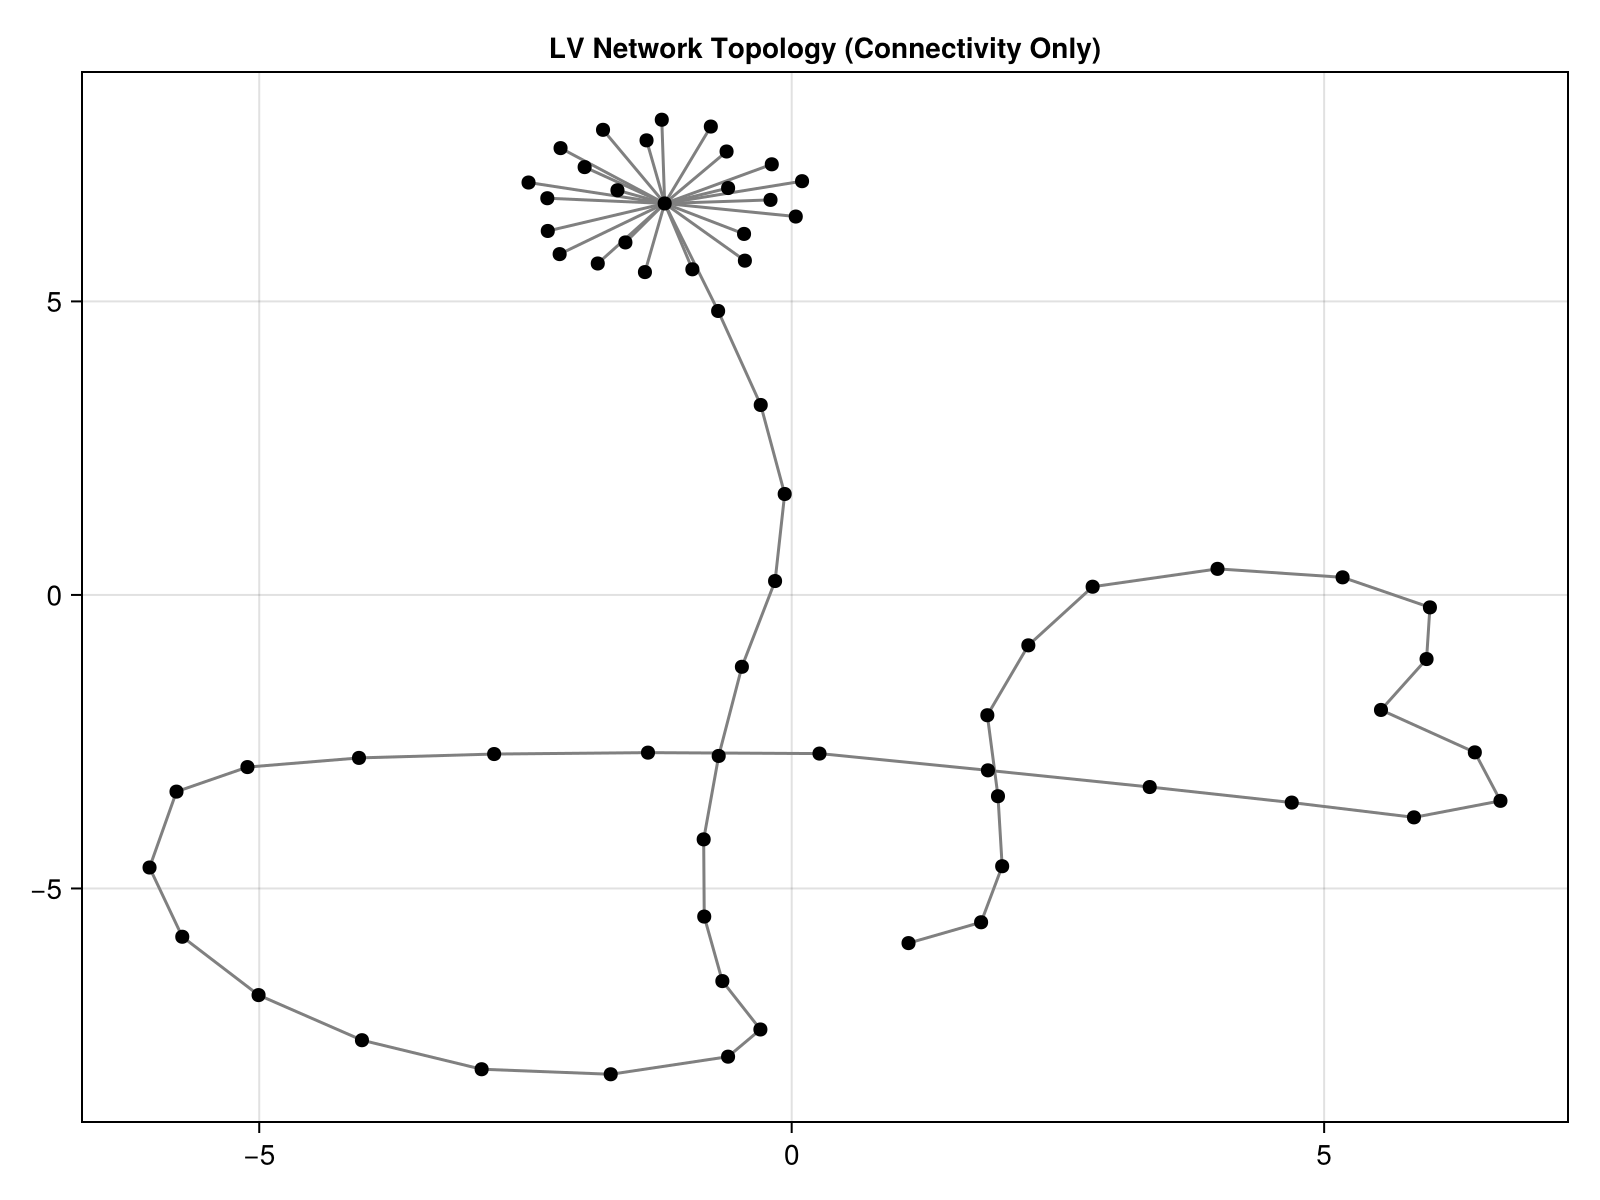

In [ ]:
f = Figure(size = (800, 600))
ax = Axis(f[1,1], title = "LV Network Topology (Connectivity Only)")

graphplot!(
    ax,
    g,
    node_size = 10,
    node_color = :black,
    edge_color = :gray
)

f


### LV Network Topology (Source Bus Highlighted)

In [ ]:
slack_id = "sourcebus"


"sourcebus"

In [ ]:
bus_ids = collect(keys(eng4w["bus"]))
bus_index = Dict(bus_ids[i] => i for i in eachindex(bus_ids))


Dict{String, Int64} with 65 entries:
  "32" => 1
  "29" => 2
  "1"  => 3
  "54" => 4
  "2"  => 5
  "41" => 6
  "53" => 7
  "51" => 8
  "27" => 9
  "42" => 10
  "33" => 11
  "28" => 12
  "52" => 13
  "50" => 14
  "63" => 15
  "26" => 16
  "10" => 17
  "24" => 18
  "58" => 19
  "25" => 20
  "23" => 21
  "49" => 22
  "59" => 23
  "31" => 24
  "5"  => 25
  ⋮    => ⋮

In [ ]:
slack_idx = bus_index[slack_id]


60

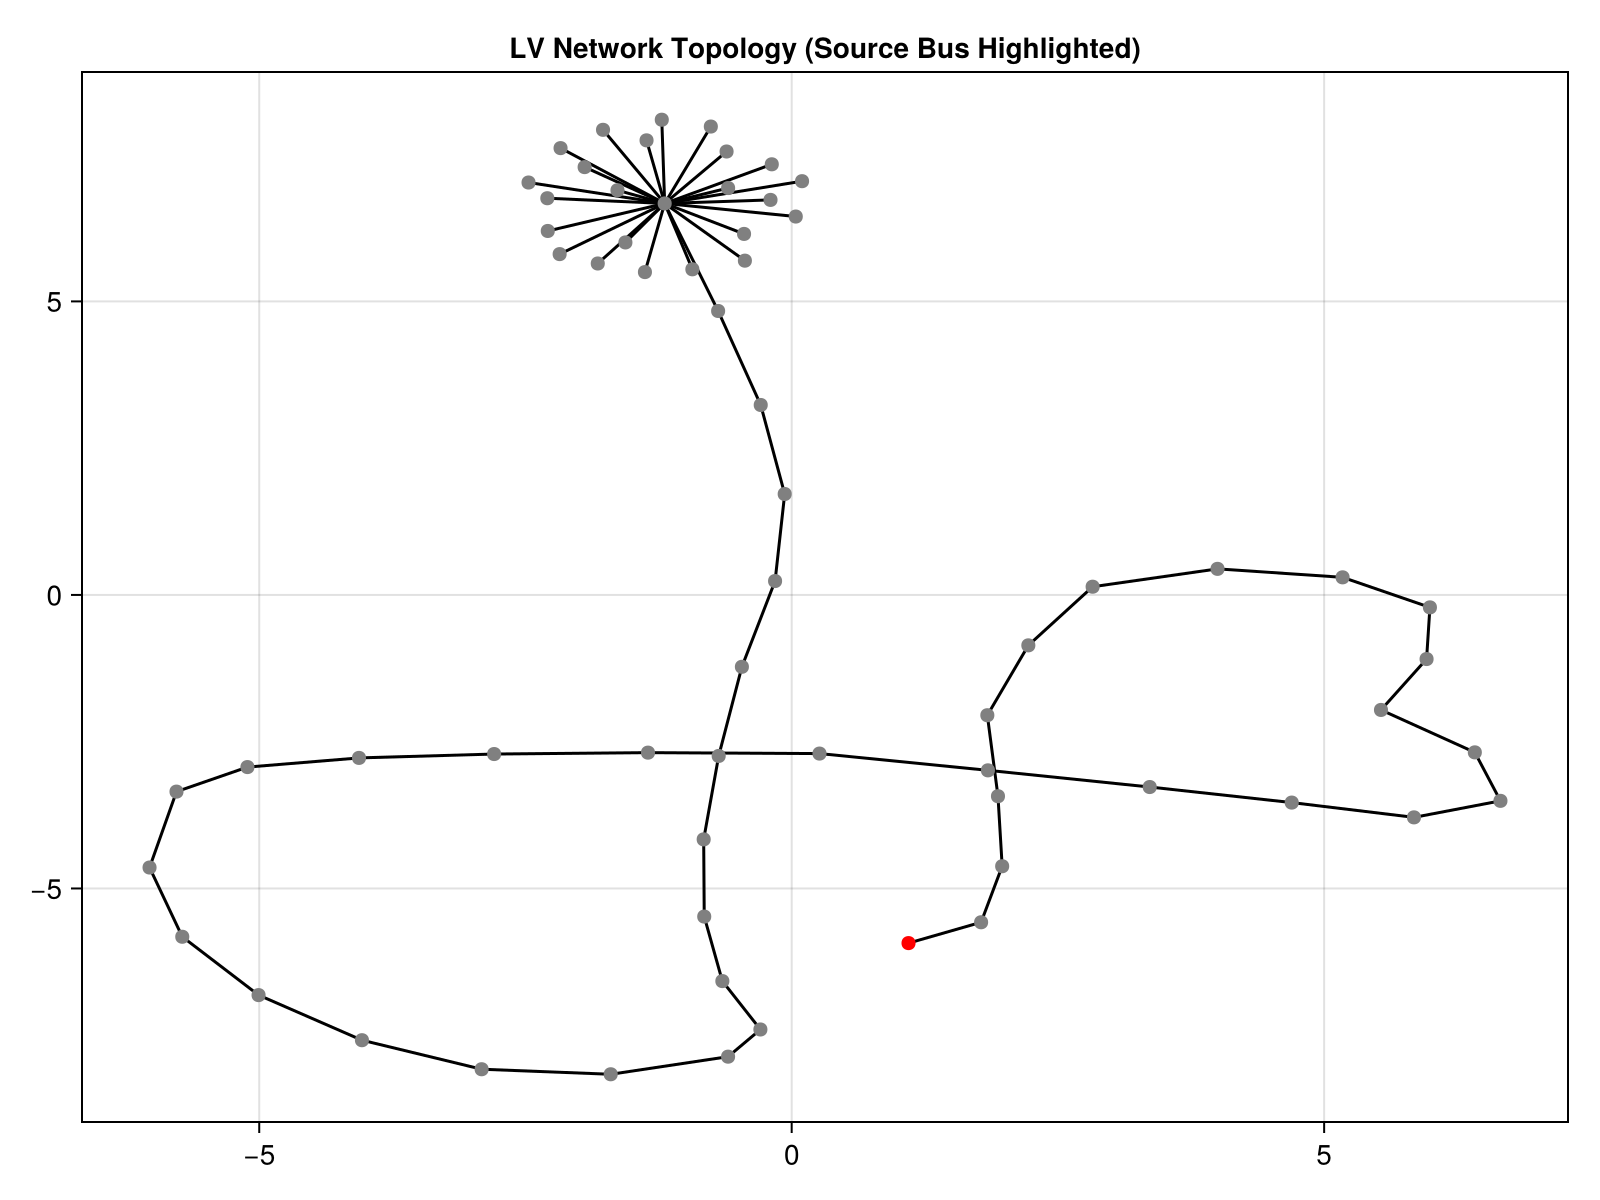

In [ ]:
node_colors = fill(:gray, nv(g))
node_colors[slack_idx] = :red

f1 = Figure(size = (800, 600))
ax = Axis(f1[1,1], title = "LV Network Topology (Source Bus Highlighted)")

graphplot!(
    ax,
    g,
    node_size = 10,
    node_color = node_colors,
    edge_color = :black
)

f1

### LV Network Topology (with Electrical distance from Source Bus)

In [ ]:
dist = dijkstra_shortest_paths(g, slack_idx).dists


65-element Vector{Int64}:
 32
 29
  1
 42
  2
 41
 42
 42
 27
 42
 33
 28
 42
  ⋮
 40
 42
 38
 21
 42
 42
  0
 36
 42
 18
 30
  3

In [ ]:
dist_norm = dist ./ maximum(dist)


65-element Vector{Float64}:
 0.7619047619047619
 0.6904761904761905
 0.023809523809523808
 1.0
 0.047619047619047616
 0.9761904761904762
 1.0
 1.0
 0.6428571428571429
 1.0
 0.7857142857142857
 0.6666666666666666
 1.0
 ⋮
 0.9523809523809523
 1.0
 0.9047619047619048
 0.5
 1.0
 1.0
 0.0
 0.8571428571428571
 1.0
 0.42857142857142855
 0.7142857142857143
 0.07142857142857142

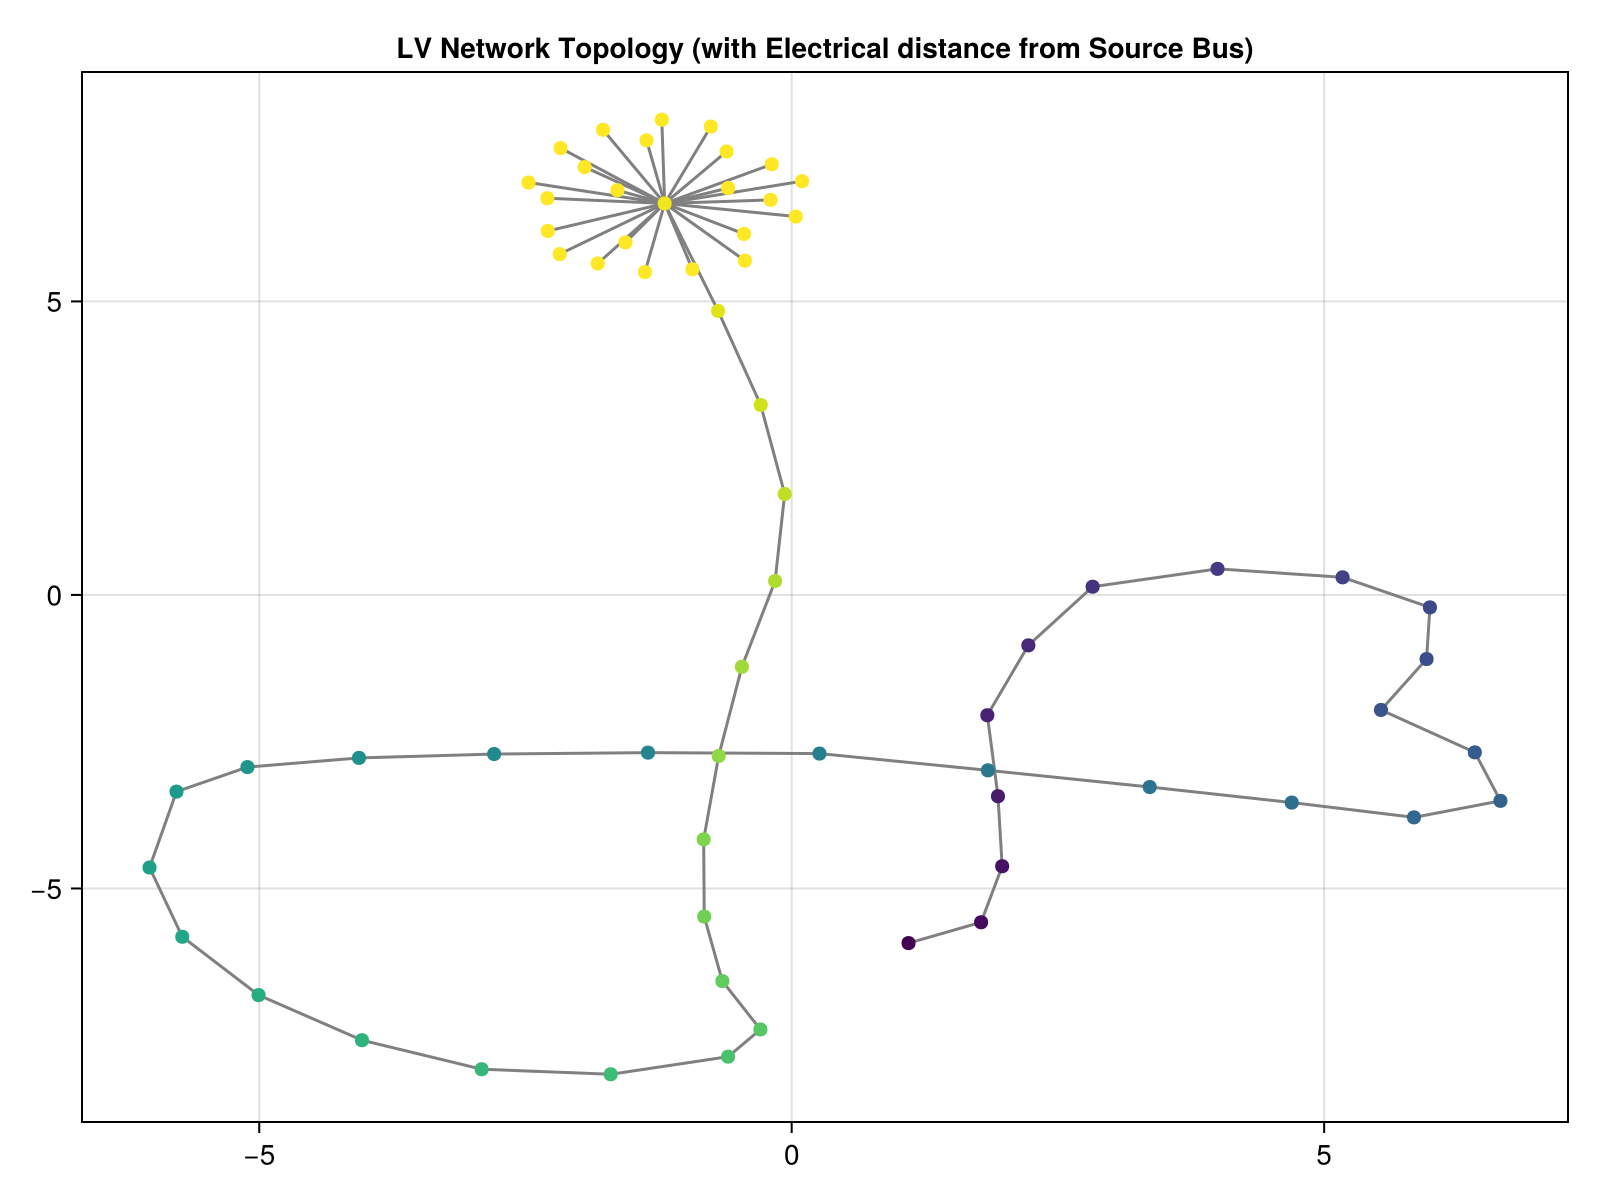

In [ ]:
node_colors = fill(:gray, nv(g))
node_colors[slack_idx] = :red

f2 = Figure(size = (800, 600))
ax = Axis(f2[1,1], title = "LV Network Topology (with Electrical distance from Source Bus)")

graphplot!(
    ax,
    g,
    node_size = 10,
    node_color = dist_norm,
    colormap = :viridis,
    edge_color = :gray
)

f2

### LV Network Topology – Baseline Voltage Profile

In [ ]:
using Statistics

df_bus_vm = combine(
    groupby(df_v, :bus),
    :vm_pu => mean => :vm_mean
)

LoadError: UndefVarError: `df_v` not defined

In [ ]:
vm_map = Dict(row.bus => row.vm_mean for row in eachrow(df_bus_vm))

vm_vec = [
    vm_map[bus_id] for bus_id in bus_ids
]


In [ ]:
using CairoMakie
using GraphMakie

f3 = Figure(size = (900, 700))
ax = Axis(
    f3[1,1],
    title = "LV Network Topology – Baseline Voltage Profile",
    xlabel = "",
    ylabel = ""
)

graphplot!(
    ax,
    g,
    node_color = vm_vec,
    colormap = :plasma,
    node_size = 12,
    edge_color = :gray
)

Colorbar(f3[1,2], limits = extrema(vm_vec), label = "Voltage (p.u.)")

f3

### Daisy plot

In [ ]:
dist = dijkstra_shortest_paths(g, slack_idx).dists


In [ ]:
scatter(
    dist,
    vm_vec,
    xlabel = "Electrical Distance from Transformer",
    ylabel = "Voltage (p.u.)",
    title = "Baseline Voltage Profile Along Feeder",
    markersize = 10
)
hline!([V_MIN, V_MAX], linestyle = :dash)

